In [1]:
from google.colab import drive
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Path ke folder utama
base_dir = '/content/drive/MyDrive/klasifikasiikan'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#setup global
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path
checkpoint_path = '/content/drive/MyDrive/klasifikasiikan/checkpoint_model.h5'
epoch_log_path = '/content/drive/MyDrive/klasifikasiikan/last_epoch.txt'

# Epoch control
TOTAL_EPOCHS = 10
EPOCHS_PER_RUN = 3


In [3]:
#augmentasi data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

# Path ke masing-masing folder
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1766 images belonging to 31 classes.


In [4]:
#CNN Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D,
                                     Dropout, Dense, Flatten,
                                     BatchNormalization, LeakyReLU,
                                     GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Get the number of classes from the train_generator
num_classes = train_generator.num_classes

model = Sequential()

# 1st Block
model.add(Conv2D(32, (3,3), padding='same', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2)))

# 2nd Block
model.add(Conv2D(64, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2)))

# 3rd Block
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Fully Connected
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(num_classes, activation='softmax')) # Now num_classes is defined

# Compile
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [5]:
#model builder
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(128, 128, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')  # ganti jumlah kelas
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
)
    return model

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]
class EpochLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        with open(epoch_log_path, 'w') as f:
            f.write(str(epoch + 1))


In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Simpan checkpoint ke Google Drive
checkpoint_path = '/content/drive/MyDrive/klasifikasiikan/checkpoint_model.h5'

checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,   # hanya simpan model dengan val_loss terbaik
    monitor='val_loss',
    mode='min',
    verbose=1
)

In [7]:
#training 3 epoch batch
import tensorflow as tf # Importing tensorflow
import os # Importing os module for file operations

# Load last epoch from file, or start from 0 if the file doesn't exist
epoch_log_path = '/content/drive/MyDrive/klasifikasiikan/last_epoch.txt'  # Update path if necessary
if os.path.exists(epoch_log_path):
    with open(epoch_log_path, 'r') as f:
        last_epoch = int(f.read())
else:
    last_epoch = 0

next_epoch = min(last_epoch + EPOCHS_PER_RUN, TOTAL_EPOCHS)

if last_epoch >= TOTAL_EPOCHS:
    print("✅ Training selesai.")
else:
    print(f"🏃‍♂️ Training dari epoch {last_epoch} sampai {next_epoch}...")

    checkpoint_cb = ModelCheckpoint(
        filepath=checkpoint_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )

    # Enable eager execution
    tf.config.run_functions_eagerly(True) #Enabling eager execution

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=next_epoch,
        initial_epoch=last_epoch,
        callbacks=[checkpoint_cb, EpochLogger()]
    )

    # Disable eager execution (optional) if you want to revert to the default behavior
    tf.config.run_functions_eagerly(False) #Disabling eager execution to revert to default behavior

🏃‍♂️ Training dari epoch 6 sampai 9...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 7/9


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.1352 - loss: 3.2939 
Epoch 7: val_loss improved from inf to 3.77600, saving model to /content/drive/MyDrive/klasifikasiikan/checkpoint_model.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 3772s 14s/step - accuracy: 0.1353 - loss: 3.2933 - val_accuracy: 0.1338 - val_loss: 3.7760
Epoch 8/9
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2098 - loss: 2.9449
Epoch 8: val_loss improved from 3.77600 to 2.75342, saving model to /content/drive/MyDrive/klasifikasiikan/checkpoint_model.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 809s 3s/step - accuracy: 0.2098 - loss: 2.9449 - val_accuracy: 0.2454 - val_loss: 2.7534
Epoch 9/9
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2100 - loss: 2.8511
Epoch 9: val_loss did not improve from 2.75342
276/276 ━━━━━━━━━━━━━━━━━━━━ 841s 3s/step - accuracy: 0.2101 - loss: 2.8510 - val_accuracy: 0.1818 - val_loss: 3.0131


In [8]:
#evaluasi test data
# Evaluasi pada data test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 523s 9s/step - accuracy: 0.1655 - loss: 3.2465
Test Accuracy: 0.1795 | Test Loss: 3.0260


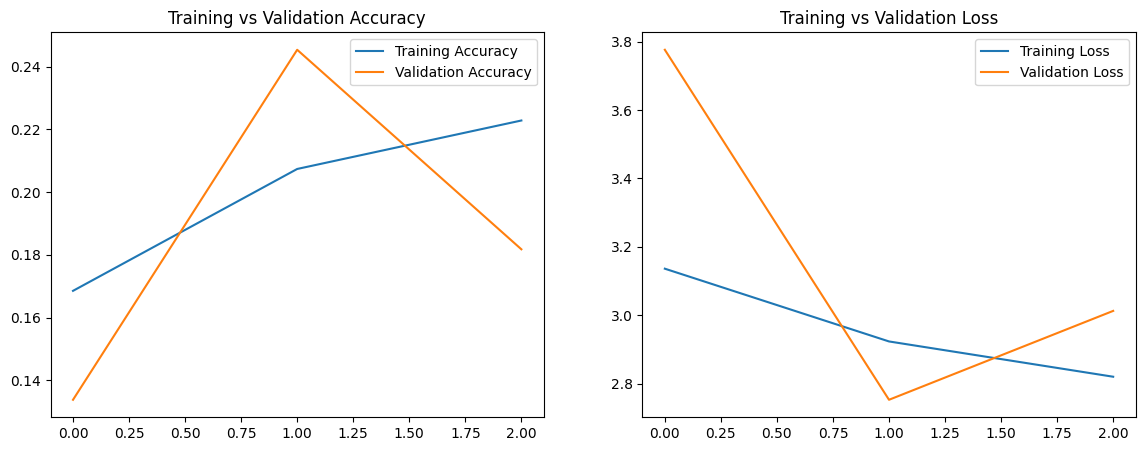

In [9]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()


86/86 ━━━━━━━━━━━━━━━━━━━━ 50s 580ms/step


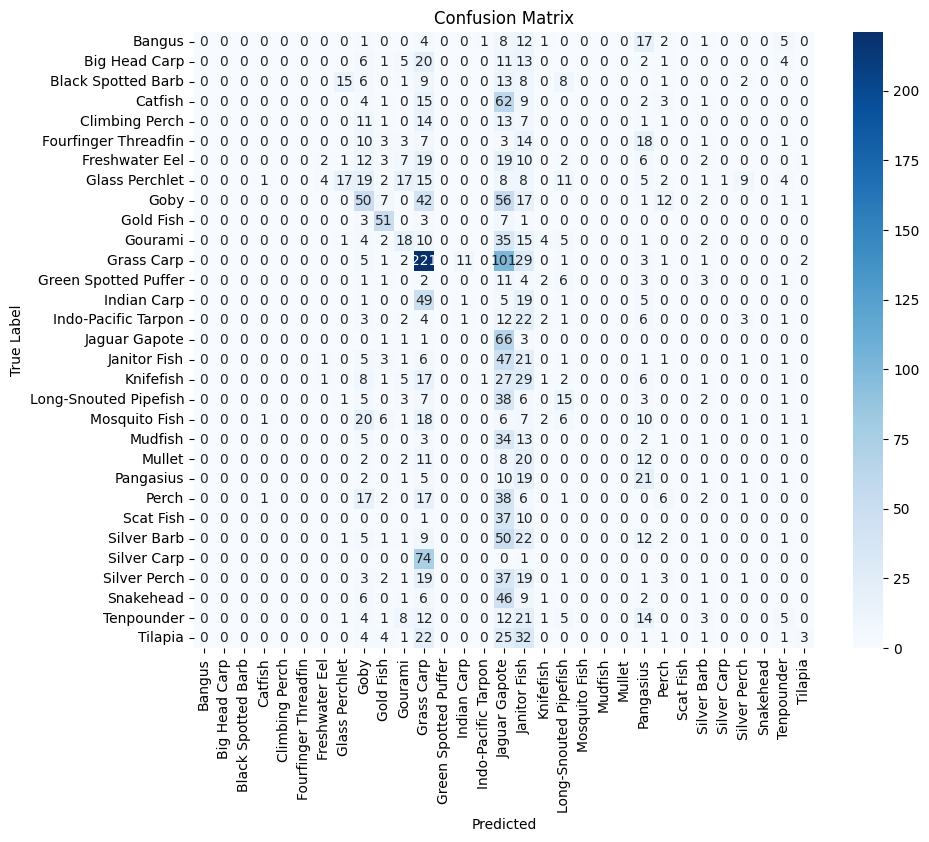

                       precision    recall  f1-score   support

               Bangus       0.00      0.00      0.00        52
        Big Head Carp       0.00      0.00      0.00        63
   Black Spotted Barb       0.00      0.00      0.00        63
              Catfish       0.00      0.00      0.00        97
       Climbing Perch       0.00      0.00      0.00        48
 Fourfinger Threadfin       0.00      0.00      0.00        60
       Freshwater Eel       0.25      0.02      0.04        84
       Glass Perchlet       0.46      0.14      0.21       124
                 Goby       0.23      0.26      0.24       189
            Gold Fish       0.54      0.78      0.64        65
              Gourami       0.22      0.19      0.20        97
           Grass Carp       0.33      0.58      0.42       378
 Green Spotted Puffer       0.00      0.00      0.00        34
          Indian Carp       0.08      0.01      0.02        81
  Indo-Pacific Tarpon       0.00      0.00      0.00  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Ambil true label dan prediksi
val_generator.reset()
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(val_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))


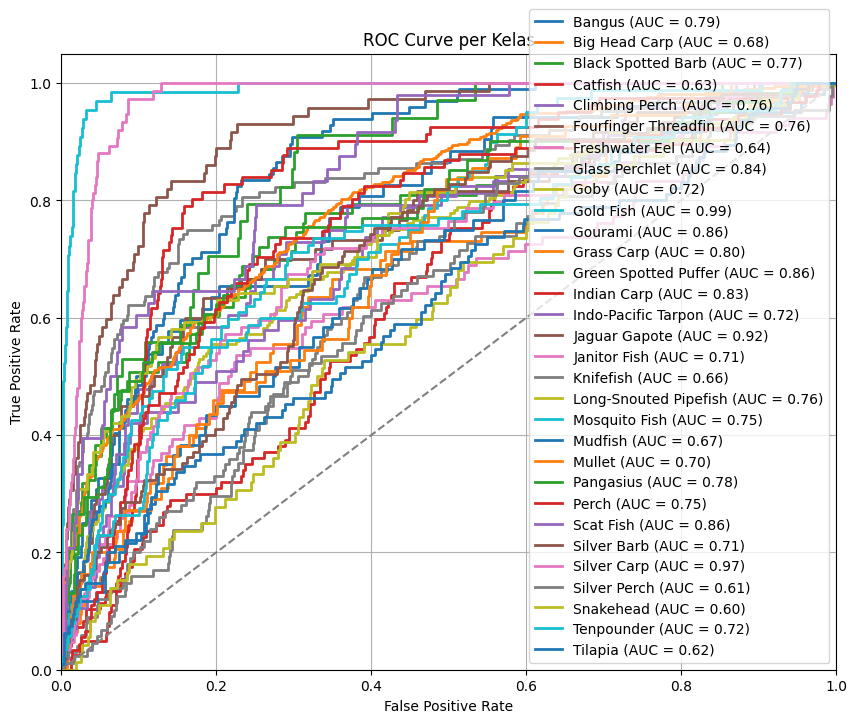

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binarisasi label ground truth (jika belum)
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true, classes=list(range(train_generator.num_classes)))

# Siapkan ROC curve untuk tiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Garis baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
